In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

In [2]:
from google.colab import files
uploaded = files.upload()

Saving data.csv to data.csv


In [3]:
import pandas as pd
import numpy as np
import torch
# ... (rest of your imports)

# Step 1: Load data and transform to z
df = pd.read_csv('data.csv', encoding='latin1')
print("Columns in dataset:", df.columns.tolist())  # helpful to see exact column names

x = df['no2'].dropna().values

Columns in dataset: ['stn_code', 'sampling_date', 'state', 'location', 'agency', 'type', 'so2', 'no2', 'rspm', 'spm', 'location_monitoring_station', 'pm2_5', 'date']


/tmp/ipython-input-2311817425.py:7: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data.csv', encoding='latin1')


In [4]:
r = 102303531
a_r = 0.5 * (r % 7)
b_r = 0.3 * (r % 5 + 1)
print(f"Transformation parameters: a_r = {a_r}, b_r = {b_r}")

z = x + a_r * np.sin(b_r * x)
z = z.astype(np.float32)  # For PyTorch

Transformation parameters: a_r = 0.5, b_r = 0.6


In [5]:
# Prepare data loader for real z
z_tensor = torch.from_numpy(z).unsqueeze(1)  # Shape (N, 1)
dataset = TensorDataset(z_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

In [7]:
class Generator(nn.Module):
    def __init__(self, noise_dim=100):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, noise):           # ← This line + body is required
        return self.model(noise)

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):               # ← Add this if missing
        return self.model(x)

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Use only subset for faster training
z_subset = z[:15000]   # VERY IMPORTANT (reduce size)

# Convert to tensor
z_tensor = torch.tensor(z_subset, dtype=torch.float32).view(-1,1)

dataset = TensorDataset(z_tensor)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [13]:
noise_dim = 50
generator = Generator(noise_dim).to(device)
discriminator = Discriminator().to(device)

criterion = nn.BCELoss()

g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)


In [14]:
epochs = 80   # reduced for faster training

for epoch in range(epochs):

    for real_batch in dataloader:
        real_batch = real_batch[0].to(device)
        batch_size = real_batch.size(0)

        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # -------------------------
        # Train Discriminator
        # -------------------------
        d_optimizer.zero_grad()

        noise = torch.randn(batch_size, noise_dim).to(device)
        fake_data = generator(noise).detach()

        d_real = discriminator(real_batch)
        d_fake = discriminator(fake_data)

        d_loss = criterion(d_real, real_labels) + \
                 criterion(d_fake, fake_labels)

        d_loss.backward()
        d_optimizer.step()

        # -------------------------
        # Train Generator
        # -------------------------
        g_optimizer.zero_grad()

        noise = torch.randn(batch_size, noise_dim).to(device)
        fake_data = generator(noise)
        output = discriminator(fake_data)

        g_loss = criterion(output, real_labels)

        g_loss.backward()
        g_optimizer.step()

    # Print progress
    if epoch % 10 == 0:
        print(f"Epoch [{epoch}/{epochs}]  D Loss: {d_loss.item():.4f}  G Loss: {g_loss.item():.4f}")


Epoch [0/80]  D Loss: 0.4622  G Loss: 1.1932
Epoch [10/80]  D Loss: 1.3672  G Loss: 0.7345
Epoch [20/80]  D Loss: 1.3786  G Loss: 0.6535
Epoch [30/80]  D Loss: 1.3890  G Loss: 0.6869
Epoch [40/80]  D Loss: 1.3921  G Loss: 0.6902
Epoch [50/80]  D Loss: 1.3780  G Loss: 0.6571
Epoch [60/80]  D Loss: 1.3866  G Loss: 0.6214
Epoch [70/80]  D Loss: 1.3760  G Loss: 0.6805


In [15]:
#After training generate samples
with torch.no_grad():
    noise = torch.randn(10000, noise_dim).to(device)
    generated_samples = generator(noise).cpu().numpy().flatten()


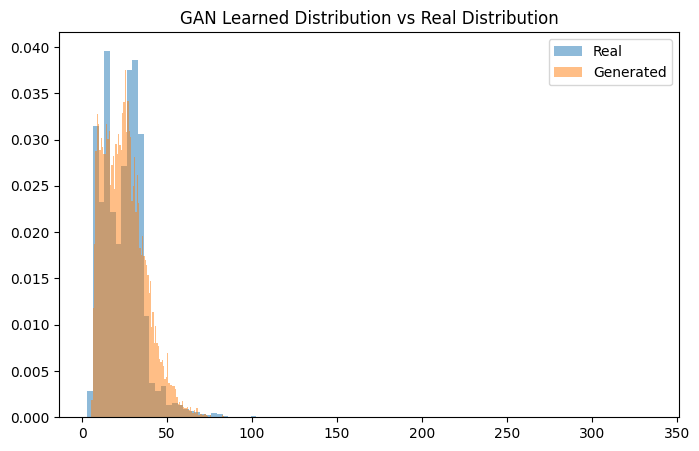

In [16]:
#Estimate pdf using histogram
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(z_subset, bins=100, density=True, alpha=0.5, label="Real")
plt.hist(generated_samples, bins=100, density=True, alpha=0.5, label="Generated")
plt.legend()
plt.title("GAN Learned Distribution vs Real Distribution")
plt.show()
